## Policy Note

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [2]:
def process_country_data(country_code):
    # Load Excel files into DataFrames
    dc = pd.read_excel(f"deficitcomptable.{country_code}.xlsx", index_col='period')
    pb = pd.read_excel(f"ProdBrut.{country_code}.xlsx", index_col='period')
    inn = pd.read_excel(f"interest.{country_code}.xlsx", index_col='period')
    PIB = pd.read_excel("PIB.xlsx")

    # Process index for each DataFrame
    dc.index = pd.to_datetime(dc.index, format='%Y')
    pb.index = pd.PeriodIndex(pb.index, freq='Q').to_timestamp()
    inn.index = pd.to_datetime(inn.index, format='%Y')

    # Sum the data annually
    pb = pb.resample('A').sum()

    # Adjust indexes to be year only
    pb.index = pb.index.year
    dc.index = dc.index.year
    inn.index = inn.index.year

    # Filter and process PIB data
    PIB = PIB[PIB['country'] == country_code]
    PIB.index = PIB['year']
    PIB = PIB[['debtgdp']]

    # Merge DataFrames by year index
    df = pd.merge(pb, dc, left_index=True, right_index=True)
    df = pd.merge(df, PIB, left_index=True, right_index=True)
    df = pd.merge(df, inn, left_index=True, right_index=True)

    # Rename columns
    df.columns = ['Produit intérieur brut', 'Capacité (+) ou besoin (-)', 'debtgdp', 'interest']

    # Adjust units
    df['Produit intérieur brut'] = df['Produit intérieur brut'] / 1000
    df['Capacité (+) ou besoin (-)'] = df['Capacité (+) ou besoin (-)'] / 1000
    df['interest'] = df['interest'] / 1000

    df['interest Percent of GDP'] = (df['interest'] / df['Produit intérieur brut'])*-100

    # Calculate additional metrics
    df['dette'] = df['debtgdp'] * df['Produit intérieur brut']
    df['variation dette'] = df['dette'].diff()
    df['adjust flux'] = df['variation dette'] - (df['Capacité (+) ou besoin (-)'] * -1)
    df['adjust flux sur PIB'] = (df['adjust flux'] / df['Produit intérieur brut']) * 100
    df['Deficit sur PIB'] = (df['Capacité (+) ou besoin (-)'] * -1 / df['Produit intérieur brut']) * 100
    df['plus ASF'] = (((df['Capacité (+) ou besoin (-)'] * -1 - df['interest']) / df['Produit intérieur brut']) * 100) + df['adjust flux sur PIB']
    df['déficit primaire comptable en % pib '] = (((df['Capacité (+) ou besoin (-)'] * -1 - df['interest']) / df['Produit intérieur brut']) * 100)

    # Calculate term r-g
    left = df['Produit intérieur brut'].pct_change() * df['dette'] / df['Produit intérieur brut']
    right = df['interest'] / df['Produit intérieur brut']
    df['term r-g'] = (right - left) * 100

    return df



In [3]:
def plot_data(df, country_code):
    # RED BLUE GRAPH
    colors = ['blue', 'red', 'orange']  # Colors for each stack
    ax = df[['adjust flux sur PIB', 'Deficit sur PIB', 'interest Percent of GDP']].plot(kind='bar', stacked=True, color=colors)

    plt.legend(["adjustement stock flux", "déficit public", "charge d'interet/PIB"])

    # Set x-ticks to display every other year
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2], minor=False)
    ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_major_formatter(PercentFormatter(100.0))

    plt.title(f'Composantes deficit primaire - {country_code}')
    plt.xlabel('Annee')
    plt.ylabel('Fraction de PIB')

    # Save the plot
    plt.savefig(f'{country_code}_Fig1.png')
    plt.show()
    plt.close()

    # RED GREEN GRAPH
    colors = ['red', 'green']  # Red for 'plus ASF', Green for 'term r-g'
    ax = df[['plus ASF', 'term r-g']].plot(kind='bar', stacked=True, color=colors)

    plt.legend(["déficit primaire + ASF", "terme r-g"])

    # Set x-ticks to display every other year
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2], minor=False)
    ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_major_formatter(PercentFormatter(100.0))

    plt.title(f'Dynamique de la dette - {country_code}')
    plt.xlabel('Annee')
    plt.ylabel('Fraction de PIB')

    # Save the plot
    plt.savefig(f'{country_code}_Fig2.png')
    plt.show()  
    plt.close()


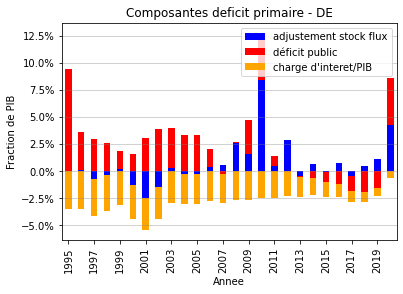

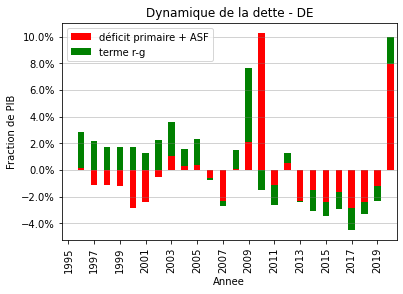

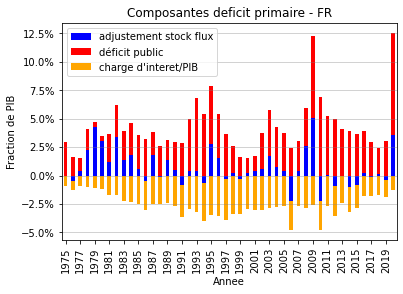

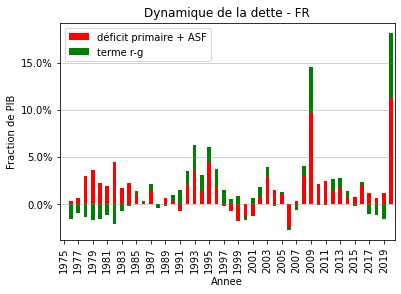

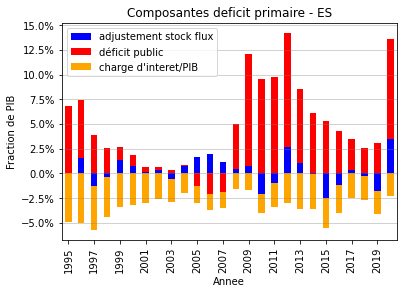

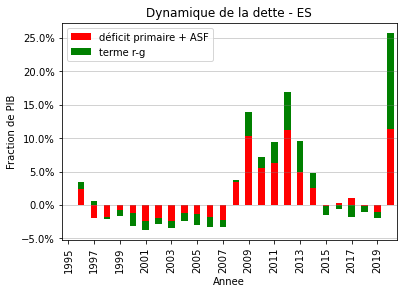

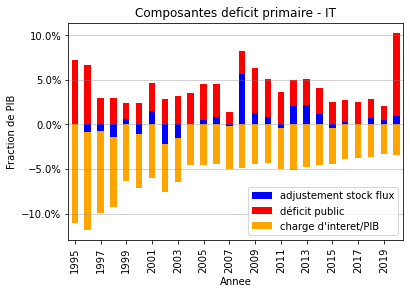

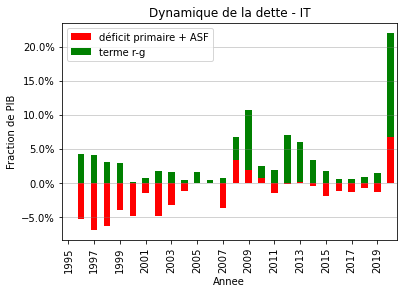

In [4]:
# List of country codes
countries = ['DE', 'FR', 'ES', 'IT']

# Process data and plot for each country
for country in countries:
    df = process_country_data(country)
    globals()[f'df_{country}'] = df  # Create DataFrame variable for each country
    plot_data(df, country)

In [5]:
df_IT

,Produit intérieur brut,Capacité (+) ou besoin (-),debtgdp,interest,interest Percent of GDP,dette,variation dette,adjust flux,adjust flux sur PIB,Deficit sur PIB,plus ASF,déficit primaire comptable en % pib,term r-g
1995,988.2432,-71.255,1.168275,109.735,-11.104048,1154.539727,NaN,NaN,NaN,7.210270,NaN,-3.893778,NaN
1996,1045.8699,-69.181,1.161658,115.523,-11.045638,1214.942843,60.403117,-8.777883,-0.839290,6.614685,-5.270243,-4.430953,4.271748
1997,1092.3573,-32.570,1.134476,99.816,-9.137670,1239.253233,24.310389,-8.259611,-0.756127,2.981625,-6.912172,-6.156044,4.095088
1998,1138.8561,-34.032,1.103548,89.279,-7.839357,1256.782699,17.529467,-16.502533,-1.449045,2.988262,-6.300140,-4.851096,3.141840
1999,1175.1494,-20.833,1.093568,74.863,-6.370509,1285.106130,28.323430,7.490430,0.637402,1.772796,-3.960311,-4.597713,2.885503
2000,1241.5128,-30.086,1.048866,75.897,-6.113268,1302.180439,17.074309,-13.011691,-1.048051,2.423334,-4.737985,-3.689934,0.190080
2001,1304.1369,-41.606,1.045345,79.015,-6.058796,1363.272543,61.092104,19.486104,1.494176,3.190309,-1.374311,-2.868487,0.785893
2002,1350.2589,-38.743,1.016453,73.360,-5.433032,1372.474594,9.202051,-29.540949,-2.187799,2.869302,-4.751529,-2.563731,1.838253
2003,1394.6932,-44.876,1.001569,69.093,-4.953993,1396.881001,24.406407,-20.469593,-1.467677,3.217625,-3.204045,-1.736368,1.658032
2004,1452.3191,-50.524,0.996955,66.751,-4.596166,1447.896605,51.015604,0.491604,0.033850,3.478850,-1.083467,-1.117316,0.476950
